In [1]:
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import summarize, ModelSpec
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.core.display import Markdown
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut


import warnings

warnings.simplefilter("ignore")

In [2]:
# ex 2(h) code


rng = np.random.default_rng(10)
store = np.empty(10000)
for i in range(10000):
    store[i] = np.sum(rng.choice(100, size=100, replace=True) == 4) > 0
np.mean(store)

0.6362

# 5
     In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the Default data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.
    
    5. (a). Fit a logistic regression model that uses income and balance to predict default.

In [3]:
def cm(y_pred, y_test):
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred).T,
        columns=["true negative", "true positive"],
        index=["pred negative", "pred positive"],
    )


# y_pred2 = (model.predict_proba(X)[:, 1] >= 0.2).astype(bool)


data: pd.DataFrame = load_data("Default")  # type: ignore

display(Markdown("### Default data"), data)

ny = {"No": 0, "Yes": 1}
for col in [
    "default",
    "student",
]:
    data[col] = data[col].map(ny)
X = data[
    [
        # "student",
        "balance",
        "income",
    ]
]
y = data.loc[:, "default"]
model = LogisticRegression(penalty=None)
model.fit(X, y)
y_pred = model.predict(X)
display(Markdown("### Confusion matrix for full fit"), cm(y, y_pred))

### Default data

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


### Confusion matrix for full fit

,true negative,true positive
pred negative,9629,38
pred positive,225,108


    (b) Using the validation set approach, estimate the test error of this model. 
        In order to do this, you must perform the following steps:
        i. Split the sample set into a training set and a validation set.
        ii. Fit a multiple logistic regression model using only the training observations.
        iii. Obtain a prediction of default status for each individual in the validation 
             set by computing the posterior probability of default for that individual, 
             and classifying the individual to the default category if the posterior probability 
             is greater than 0.5.
        iv. Compute the validation set error, which is the fraction of the observations in the 
            validation set that are misclassified.

In [4]:
def sol5b(rng_seed, train_size, threshold=0.5):
    """uses global vars X,y"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=rng_seed
    )

    model = LogisticRegression(penalty=None)
    model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)
    y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(bool)
    c = cm(y_pred, y_test)
    val_error = (c.iloc[0, 1] + c.iloc[1, 0]) / (  # type: ignore
        c.iloc[0, 0] + c.iloc[1, 0] + c.iloc[0, 1] + c.iloc[1, 1]  # type: ignore
    )

    return c, val_error


_ = [display(x) for x in sol5b(42, 0.7)]

,true negative,true positive
pred negative,2905,94
pred positive,1,0


0.03166666666666667

      5.(c). Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. 
      Comment on the results obtained.

In [5]:
_ = [[display(x) for x in [f"{seed=}", *sol5b(seed, 0.7)]] for seed in range(3)]

'seed=0'

,true negative,true positive
pred negative,2880,75
pred positive,7,38


0.027333333333333334

'seed=1'

,true negative,true positive
pred negative,2893,58
pred positive,16,33


0.024666666666666667

'seed=2'

,true negative,true positive
pred negative,2906,53
pred positive,18,23


0.023666666666666666

my comment: all equally sucky (recall: error looks small but the trivial classifier is close by)

    (d) Now consider a logistic regression model that predicts the prob- ability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the val- idation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [6]:
X = data[["student", "balance", "income"]]
_ = [[display(x) for x in [f"{seed=}", *sol5b(seed, 0.7)]] for seed in [42, 0, 1, 2]]

'seed=42'

,true negative,true positive
pred negative,2884,75
pred positive,22,19


0.03233333333333333

'seed=0'

,true negative,true positive
pred negative,2870,93
pred positive,17,20


0.03666666666666667

'seed=1'

,true negative,true positive
pred negative,2888,75
pred positive,21,16


0.032

'seed=2'

,true negative,true positive
pred negative,2904,58
pred positive,20,18


0.026

# My comment - no improvement 🥲

## 6
    We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coeffi- cients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the sm.GLM() function. Do not forget to set a random seed before beginning your analysis.
    
    (a) Using the summarize() and sm.GLM() functions, determine the estimated standard errors for the coefficients associated with income and balance in a multiple logistic regression model that uses both predictors.

In [7]:
rng = np.random.default_rng(0)

data: pd.DataFrame = load_data("Default")  # type: ignore
vars = data.columns.drop(["default", "student"])
design = ModelSpec(vars)
X: pd.DataFrame = design.fit_transform(data)  # type: ignore
# X["student"] = (X["student"] == "Yes").astype(int) # question is not about student

y = data["default"] == "Yes"
model = sm.GLM(
    y,
    X,
    penalty=None,
    family=sm.families.Binomial(),
)

results = model.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-11.540500,0.435000,-26.544,0.0
balance,0.005600,0.000000,24.835,0.0
income,0.000021,0.000005,4.174,0.0


    (b) Write a function, boot_fn(), that takes as input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for income and balance in the multiple logistic regression model.

In [8]:
def boot_fn(data: pd.DataFrame, index: list[int]) -> pd.DataFrame:
    design = ModelSpec(data.columns.drop(["default", "student"]))
    X: pd.DataFrame = design.fit_transform(data)  # type: ignore
    y = data["default"] == "Yes"
    X, y = X.iloc[index], y.iloc[index]  # type: ignore
    model = sm.GLM(
        y,
        X,
        penalty=None,
        family=sm.families.Binomial(),
    )
    results = model.fit()
    return summarize(results).loc[["balance", "income"], "coef"]  # type: ignore


# test
boot_fn(data, list(range(1000)))

balance    0.005600
income     0.000031
Name: coef, dtype: float64

    (c) Following the bootstrap example in the lab, use your boot_fn() function to estimate the standard errors of the logistic regression coefficients for income and balance.

In [9]:
N_bs = 1000
sum(
    boot_fn(data, rng.choice(data.index, 1000, replace=True))  # type: ignore
    for _ in range(N_bs)  # type: ignore
) / N_bs  # type: ignore

balance    0.005829
income     0.000021
Name: coef, dtype: float64

    (d) Comment on the estimated standard errors obtained using the sm.GLM() function and using the bootstrap.

# My comment: similar answers, but the bootstrap is slower in this case (maybe cuz loops in python suck?)

# 7
    In Sections 5.1.2 and 5.1.3, we saw that the cross_validate() function can be used in order to compute the LOOCV test error estimate. Alternatively, one could compute those quantities using just sm.GLM() and the predict() method of the fitted model within a for loop. You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the Weekly data set. Recall that in the context of classification problems, the LOOCV error is given in (5.4).

    (a) Fit a logistic regression model that predicts Direction using Lag1 and Lag2.
    (b) Fit a logistic regression model that predicts Direction using Lag1 and Lag2 using all but the first observation.
    (c) Use the model from (b) to predict the direction of the first observation. You can do this by predicting that the first observation will go up if P (Direction = "Up"|Lag1, Lag2) > 0.5. Was this observation correctly classified?
    (d) Write a for loop from i=1 to i=n, where n is the number of observations in the data set, that performs each of the following steps:
    i. Fit a logistic regression model using all but the ith observation to predict Direction using Lag1 and Lag2.
    ii. Compute the posterior probability of the market moving up for the ith observation.
    iii. Use the posterior probability for the ith observation in order to predict whether or not the market moves up.
    iv. Determine whether or not an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.
    (e) Take the average of the n numbers obtained in (d)iv in order to obtain the LOOCV estimate for the test error. Comment on the results.

In [10]:
weekly: pd.DataFrame = load_data("weekly")  # type: ignore
weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [11]:
def weekly_fn(data: pd.DataFrame, i: int) -> pd.DataFrame:
    design = ModelSpec(["Lag1", "Lag2"])
    X: pd.DataFrame = design.fit_transform(data)  # type: ignore
    y = data["Direction"] == "Up"
    model = sm.GLM(
        y.drop(i),
        X.drop(i),
        penalty=None,
        family=sm.families.Binomial(),
    )
    results = model.fit()
    pred = results.predict(X.iloc[i])[0]

    return (pred, (pred > 0.5) == y.iloc[i])  # type: ignore


display(weekly_fn(weekly, 0))
err = np.sum(1 - weekly_fn(weekly, i)[1] for i in weekly.index) / len(weekly.index)  # type: ignore
f"error rate: {err}"

(0.5713923205204429, False)

'error rate: 0.44995408631772266'

# 8
    We will now perform cross-validation on a simulated data set.
    (a) Generate a simulated data set as follows:
    ```rng = np.random.default_rng(1)
    x = rng.normal(size=100)
    y = x - 2 * x**2 + rng.normal(size=100)```
    In this data set, what is n and what is p? Write out the model used to generate the data in equation form.
    (b) Create a scatterplot of X against Y . Comment on what you find.
    (c) Set a random seed, and then compute the LOOCV errors that
    result from fitting the following four models using least squares:
    i. Y = β0 + β1X + ε
    ii. Y =β0 +β1X+β2X^2 +ε
    iii. Y =β0 +β1X+β2X^2 +β3X^3 +ε
    iv. Y =β0 +β1X+β2X^2 +β3X^3 +β4X^4 +ε.
    Note you may find it helpful to use the dataframe() function to create a single data set containing both X and Y.
    (d) Repeat (c) using another random seed, and report your results. Are your results the same as what you got in (c)? Why?
    (e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.
    (f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?



In [12]:
def q8setup(i=1):
    rng = np.random.default_rng(i)
    x = rng.normal(size=100)
    y = x - 2 * x**2 + rng.normal(size=100)
    return x, y


x, y = q8setup(1)

- $n=100$ (size of `x`). $p=1$, the only feature is `x`.
- Model: $Y = X - 2X^2 + \epsilon, \qquad \epsilon \sim N(0,1)$

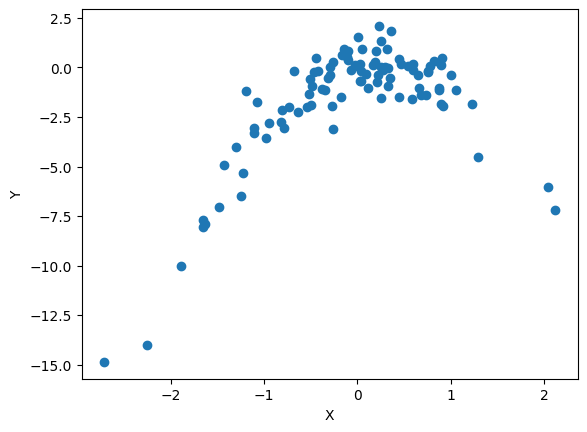

In [13]:
plt.scatter(x, y)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

The scatterplot shows a nonlinear relationship between X and Y, with a negative quadratic shape.

In [14]:
def q8():
    df = pd.DataFrame({"X": x, "Y": y})
    errors = []
    for d in [1, 2, 3, 4]:
        poly = PolynomialFeatures(degree=d)
        X_poly = poly.fit_transform(df[["X"]])
        predictions = []
        loo = LeaveOneOut()
        for train_index, test_index in loo.split(X_poly):
            X_train, X_test = X_poly[train_index], X_poly[test_index]
            y_train, y_test = df["Y"].iloc[train_index], df["Y"].iloc[test_index]
            model = LinearRegression().fit(X_train, y_train)
            y_pred = model.predict(X_test)
            predictions.append(y_pred)
        mse = mean_squared_error(df["Y"], predictions)
        errors.append(mse)

    return pd.DataFrame(zip([1, 2, 3, 4], errors), columns=["deg", "MSE"])


q8()

,deg,MSE
0,1,6.633030
1,2,1.122937
2,3,1.301797
3,4,1.332394


In [15]:
x, y = q8setup(1002)
q8()

,deg,MSE
0,1,5.862696
1,2,0.708295
2,3,0.717725
3,4,0.733872


In [16]:
x, y = q8setup(0)
_, model = q8()

In [17]:
def q8f():
    df = pd.DataFrame({"X": x, "Y": y})
    for d in [1, 2, 3, 4]:
        poly = PolynomialFeatures(degree=d)
        X_poly = poly.fit_transform(df[["X"]])
        model = sm.OLS(y, X_poly)
        display(d, summarize(model.fit()))


q8f()

1

,coef,std err,t,P>|t|
const,-1.8900,0.241,-7.827,0.000
x1,0.6907,0.250,2.762,0.007


2

,coef,std err,t,P>|t|
const,-0.0725,0.126,-0.574,0.567
x1,1.0516,0.102,10.316,0.000
x2,-1.9810,0.088,-22.532,0.000


3

,coef,std err,t,P>|t|
const,-0.0488,0.126,-0.386,0.70
x1,1.3043,0.190,6.863,0.00
x2,-1.9995,0.088,-22.708,0.00
x3,-0.1102,0.070,-1.571,0.12


4

,coef,std err,t,P>|t|
const,-0.0998,0.152,-0.657,0.513
x1,1.3376,0.198,6.744,0.000
x2,-1.8551,0.253,-7.332,0.000
x3,-0.1323,0.079,-1.671,0.098
x4,-0.0383,0.063,-0.609,0.544


# 9. 
    We will now consider the Boston housing data set, from the ISLP library.
    (a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate μˆ.
    (b) Provide an estimate of the standard error of μˆ. Interpret this result.
    Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.
    (c) Now estimate the standard error of μˆ using the bootstrap. How does this compare to your answer from (b)?
    (d) Based on your bootstrap estimate from (c), provide a 95 % con- fidence interval for the mean of medv. Compare it to the results obtained by using Boston['medv'].std() and the two standard error rule (3.9).
    Hint: You can approximate a 95 % confidence interval using the formula [μˆ − 2SE(μˆ), μˆ + 2SE(μˆ)].
    (e) Based on this data set, provide an estimate, μˆmed, for the median value of medv in the population.
    (f) Wenowwouldliketoestimatethestandarderrorofμˆmed.Unfor- tunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.
    (g) Based on this data set, provide an estimate for the tenth per- centile of medv in Boston census tracts. Call this quantity μˆ0.1. (You can use the np.percentile() function.) np.
    (h) Use the bootstrap to estimate the standard error of μˆ0.1. Comment on your findings.```

In [18]:
df = load_data("boston")
mean = df[["medv"]].mean()[0]
mean

22.532806324110677

In [19]:
se = df["medv"].std() / np.sqrt(df["medv"].count())
print(se)

0.40886114749753505


In [20]:
# set the number of bootstrap samples
rng = np.random.default_rng(0)
B = 1000
# create an empty list to store the bootstrap sample means
bootstrap_means = []
# loop over the bootstrap samples
for i in range(B):
    # draw a bootstrap sample from the original data set
    bootstrap_sample = df.sample(n=df.shape[0], replace=True)
    # calculate the sample mean of medv and append it to the list
    bootstrap_mean = bootstrap_sample["medv"].mean()
    bootstrap_means.append(bootstrap_mean)
# calculate the standard deviation of the bootstrap sample means
bootstrap_se = np.std(bootstrap_means)
print(bootstrap_se)

0.40419920462842907


In [21]:
display(
    [mean - 2 * bootstrap_se, mean + 2 * bootstrap_se],
    [mean - 2 * se, mean + 2 * se],
)

[21.72440791485382, 23.341204733367533]

[21.715084029115605, 23.35052861910575]

In [22]:
df[["medv"]].median()[0]

21.2

In [23]:
# set the number of bootstrap samples
rng = np.random.default_rng(0)
B = 1000
# create an empty list to store the bootstrap sample means
bootstrap_medians = []
# loop over the bootstrap samples
for i in range(B):
    # draw a bootstrap sample from the original data set
    bootstrap_sample = df.sample(n=df.shape[0], replace=True)
    # calculate the sample mean of medv and append it to the list
    bootstrap_median = bootstrap_sample["medv"].median()
    bootstrap_medians.append(bootstrap_median)
# calculate the standard deviation of the bootstrap sample means
bootstrap_median_se = np.std(bootstrap_medians)
print(bootstrap_median_se)

0.37270521528414347


In [24]:
df[["medv"]].quantile(0.1)

medv    12.75
Name: 0.1, dtype: float64

In [25]:
# set the number of bootstrap samples
rng = np.random.default_rng(0)
B = 1000
# create an empty list to store the bootstrap sample means
bootstrap_qs = []
# loop over the bootstrap samples
for i in range(B):
    # draw a bootstrap sample from the original data set
    bootstrap_sample = df.sample(n=df.shape[0], replace=True)
    # calculate the sample mean of medv and append it to the list
    bootstrap_q = bootstrap_sample["medv"].quantile(0.1)
    bootstrap_qs.append(bootstrap_q)
# calculate the standard deviation of the bootstrap sample means
bootstrap_q_se = np.std(bootstrap_qs)
print(bootstrap_q_se)

0.4971820592097023
